In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split,cross_validate
from surprise import SVD, accuracy
from surprise import KNNBasic
import os
from tensorflow.keras import backend as K
import tables

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from surprise import SVDpp, Reader, Dataset
from sklearn.preprocessing import LabelEncoder

2023-04-28 18:30:32.879534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 18:30:34.092757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from wordcloud import WordCloud

# # Download necessary resources from NLTK
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

### TASTE PROFILE DATA

In [3]:
taste_profile = pd.read_csv('/home/016651544/datasets/train_triplets.txt',sep='\t',header=None,names = ['user_id','song_id','play_count'])
taste_profile.shape

(20000, 3)

In [4]:
taste_profile.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [5]:
# Compute quartiles for the play_count of users and year of publication columns
q1_play_count = taste_profile['play_count'].quantile(0.25)
q3_play_count = taste_profile['play_count'].quantile(0.75)
iqr_play_count = q3_play_count - q1_play_count
lower_play_count = q1_play_count - 1.5 * iqr_play_count
upper_play_count = q3_play_count + 1.5 * iqr_play_count
print(q1_play_count, q3_play_count,lower_play_count, upper_play_count)

# Identify and remove outliers based on IQR
taste_profile = taste_profile[(taste_profile['play_count'] >= lower_play_count) & (taste_profile['play_count'] <= upper_play_count)]
taste_profile.shape

1.0 3.0 -2.0 6.0


(18353, 3)

In [6]:
taste_profile.song_id.nunique()

13269

### METADATA

In [7]:
# Convert the table to a Pandas DataFrame
metadata_table_df = pd.read_csv('/home/016651544/datasets/track_metadata.csv')
metadata_table_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,NaN,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [8]:
# metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
# metadata_table_df.head()
song_ids = taste_profile["song_id"].unique().astype(str)

In [9]:
metadata_df = pd.merge(pd.DataFrame(song_ids,columns=['song_id']),metadata_table_df,on="song_id",how='left')
metadata_df.head()

,song_id,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,SOAKIMP12A8C130995,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,ARC8CQZ1187B98DECA,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,112.63955,0.832012,0.677482,0,2093263,-1,0
1,SOAPDEY12A81C210A9,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,ARHYUI71187FB48366,8a7cf497-dc5c-4523-932d-3fcbc9a69d38,Billy Preston,153.59955,0.580555,0.482492,1974,3072847,-1,0
2,SOBBMDR12A8C13253B,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,ARC1SF21187FB51D0F,7bc8dd01-35ea-4b18-a64d-3a364dc76a52,Paco De Lucia,358.24281,0.633119,0.417718,1976,2631392,-1,0
3,SOBFNSP12AF72A0E22,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,ARMS97V1187B99DD98,023d64c9-93db-4a20-8c5c-2efa1a53481a,Josh Rouse,266.34404,0.675339,0.509058,2002,413957,-1,0
4,SOBFOVM12A58A7D494,TRAHZNE128F9341B86,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,ARI4V0E1187B9B6FC2,87ebbe67-3910-4521-a418-4fe53eb912b7,The Dead 60s,141.42649,0.650281,0.451749,0,5674853,-1,0


### EDA on MetaData

In [10]:
metadata_df.replace("",np.nan,inplace=True)

In [11]:
metadata_df.isna().sum()

song_id                 0
track_id                0
title                   0
release                 0
artist_id               0
artist_mbid           157
artist_name             0
duration                0
artist_familiarity      0
artist_hotttnesss       0
year                    0
track_7digitalid        0
shs_perf                0
shs_work                0
dtype: int64

In [12]:
values = {'song_hotttnesss': 0,'artist_familiarity': 0, 'title': "Unknown"}
metadata_df.fillna(value= values,inplace=True)
metadata_df.isna().sum()

song_id                 0
track_id                0
title                   0
release                 0
artist_id               0
artist_mbid           157
artist_name             0
duration                0
artist_familiarity      0
artist_hotttnesss       0
year                    0
track_7digitalid        0
shs_perf                0
shs_work                0
dtype: int64

In [13]:
metadata_df.columns,metadata_df.dtypes

(Index(['song_id', 'track_id', 'title', 'release', 'artist_id', 'artist_mbid',
        'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
        'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
       dtype='object'),
 song_id                object
 track_id               object
 title                  object
 release                object
 artist_id              object
 artist_mbid            object
 artist_name            object
 duration              float64
 artist_familiarity    float64
 artist_hotttnesss     float64
 year                    int64
 track_7digitalid        int64
 shs_perf                int64
 shs_work                int64
 dtype: object)

In [14]:
metadata_df.artist_familiarity.value_counts()

0.844085    65
0.902841    51
0.929030    51
0.918452    48
0.865022    48
            ..
0.521087     1
0.664182     1
0.571640     1
0.681509     1
0.727863     1
Name: artist_familiarity, Length: 4391, dtype: int64

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'artist_familiarity'}>],
       [<Axes: title={'center': 'artist_hotttnesss'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'shs_perf'}>,
        <Axes: title={'center': 'shs_work'}>]], dtype=object)

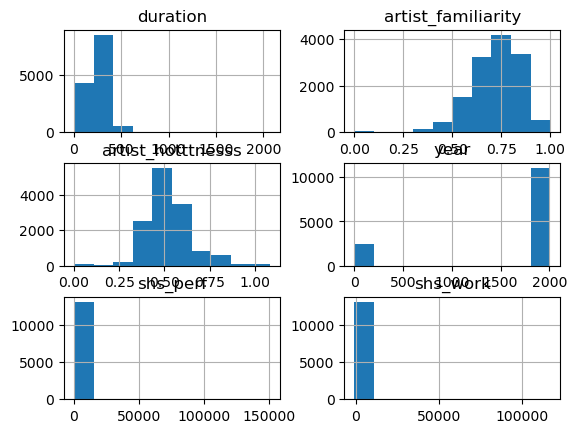

In [15]:
metadata_df[['duration', 'artist_familiarity', 'artist_hotttnesss', 'year', 'shs_perf', 'shs_work']].hist()

In [16]:
metadata_df.columns

Index(['song_id', 'track_id', 'title', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
      dtype='object')

### EDA

In [17]:
eda_data = pd.merge(taste_profile, metadata_df, on='song_id',how='left')
eda_data.head()

,user_id,song_id,play_count,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,ARC8CQZ1187B98DECA,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,112.63955,0.832012,0.677482,0,2093263,-1,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,ARHYUI71187FB48366,8a7cf497-dc5c-4523-932d-3fcbc9a69d38,Billy Preston,153.59955,0.580555,0.482492,1974,3072847,-1,0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,ARC1SF21187FB51D0F,7bc8dd01-35ea-4b18-a64d-3a364dc76a52,Paco De Lucia,358.24281,0.633119,0.417718,1976,2631392,-1,0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,ARMS97V1187B99DD98,023d64c9-93db-4a20-8c5c-2efa1a53481a,Josh Rouse,266.34404,0.675339,0.509058,2002,413957,-1,0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,ARI4V0E1187B9B6FC2,87ebbe67-3910-4521-a418-4fe53eb912b7,The Dead 60s,141.42649,0.650281,0.451749,0,5674853,-1,0


In [18]:
# Most popular songs
song_counts = eda_data['title'].value_counts()
top_songs = song_counts.head(10)
print('Top 10 most popular songs:')
for i, (song_id, count) in enumerate(top_songs.iteritems(), 1):
    print(f'{i}. Song ID: {song_id}, Count: {count}')
print()

# Most popular artists
artist_counts = eda_data['artist_name'].value_counts()
top_artists = artist_counts.head(10)
print('Top 10 most popular artists:')
for i, (artist_name, count) in enumerate(top_artists.iteritems(), 1):
    print(f'{i}. Artist: {artist_name}, Count: {count}')
print()

# Common artist names
artist_counts = eda_data['artist_name'].value_counts()
common_artists = artist_counts[artist_counts > 1]
print('Common artist names (appearing in more than 1 song):')
print(common_artists.index.values)
print()

# Common song titles
title_counts = eda_data['title'].value_counts()
common_titles = title_counts[title_counts > 1]
print('Common song titles (appearing in more than 1 song):')
print(common_titles.index.values)
print()

# Average duration
avg_duration = eda_data['duration'].mean()
print(f'Average duration: {avg_duration:.2f} seconds')

Top 10 most popular songs:
1. Song ID: Use Somebody, Count: 54
2. Song ID: Yellow, Count: 44
3. Song ID: Sehr kosmisch, Count: 43
4. Song ID: Somebody To Love, Count: 37
5. Song ID: Nothin' On You [feat. Bruno Mars] (Album Version), Count: 32
6. Song ID: The Real Slim Shady, Count: 30
7. Song ID: Love Story, Count: 28
8. Song ID: Secrets, Count: 27
9. Song ID: Dog Days Are Over (Radio Edit), Count: 26
10. Song ID: Undo, Count: 26

Top 10 most popular artists:
1. Artist: Coldplay, Count: 202
2. Artist: Kings Of Leon, Count: 154
3. Artist: Daft Punk, Count: 144
4. Artist: The Black Keys, Count: 128
5. Artist: The Killers, Count: 126
6. Artist: Eminem, Count: 110
7. Artist: Muse, Count: 92
8. Artist: Florence + The Machine, Count: 88
9. Artist: Guns N' Roses, Count: 87
10. Artist: LCD Soundsystem, Count: 83

Common artist names (appearing in more than 1 song):
['Coldplay' 'Kings Of Leon' 'Daft Punk' ... 'Brian Eno' 'Angelic Upstarts'
 'Zeca Baleiro']

Common song titles (appearing in more

/tmp/ipykernel_92137/1347986239.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (song_id, count) in enumerate(top_songs.iteritems(), 1):
/tmp/ipykernel_92137/1347986239.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (artist_name, count) in enumerate(top_artists.iteritems(), 1):


### TEXT PREPROCESSING

In [19]:
metadata_df.head()

,song_id,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,SOAKIMP12A8C130995,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,ARC8CQZ1187B98DECA,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,112.63955,0.832012,0.677482,0,2093263,-1,0
1,SOAPDEY12A81C210A9,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,ARHYUI71187FB48366,8a7cf497-dc5c-4523-932d-3fcbc9a69d38,Billy Preston,153.59955,0.580555,0.482492,1974,3072847,-1,0
2,SOBBMDR12A8C13253B,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,ARC1SF21187FB51D0F,7bc8dd01-35ea-4b18-a64d-3a364dc76a52,Paco De Lucia,358.24281,0.633119,0.417718,1976,2631392,-1,0
3,SOBFNSP12AF72A0E22,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,ARMS97V1187B99DD98,023d64c9-93db-4a20-8c5c-2efa1a53481a,Josh Rouse,266.34404,0.675339,0.509058,2002,413957,-1,0
4,SOBFOVM12A58A7D494,TRAHZNE128F9341B86,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,ARI4V0E1187B9B6FC2,87ebbe67-3910-4521-a418-4fe53eb912b7,The Dead 60s,141.42649,0.650281,0.451749,0,5674853,-1,0


In [20]:
num_columns = ['song_id','duration', 'artist_familiarity', 'artist_hotttnesss', 'year']
text_columns = ['song_id','release','title', 'artist_name']
num_meta_df = metadata_df[num_columns].copy()
text_meta_df = metadata_df[text_columns].copy()

In [21]:
import re
# Preprocess song release,title, artist name
text_meta_df['release'] = text_meta_df['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['release'] = text_meta_df['release'].apply(lambda x: x.lower()) # Convert to lowercase
# text_meta_df['release'] = text_meta_df['release'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))])) # Remove stop words

text_meta_df['title'] = text_meta_df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['title'] = text_meta_df['title'].apply(lambda x: x.lower()) # Convert to lowercase
# text_meta_df['title'] = text_meta_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))])) # Remove stop words

text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: x.lower()) # Convert to lowercase
# text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))])) # Remove stop words


In [22]:
from gensim.models import Word2Vec

text_meta_df['text'] = text_meta_df[['release','title', 'artist_name']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in text_meta_df['text']]
emb_size = 500
# Train Word2Vec model
model_w2v = Word2Vec(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)


In [23]:
# Encode metadata using Word2Vec
meta_text_vec = []
for text in text_meta_df['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_w2v.wv:
            vec += model_w2v.wv[token]
    meta_text_vec.append(vec)
meta_text_vec = np.array(meta_text_vec)
meta_text_vec.shape

(13481, 500)

In [24]:
meta_embed = pd.concat([text_meta_df['song_id'],pd.DataFrame(meta_text_vec,columns = ['embed_{}'.format(i) for i in range(meta_text_vec.shape[1])])],axis = 1)
meta_embed.head()

,song_id,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,...,embed_490,embed_491,embed_492,embed_493,embed_494,embed_495,embed_496,embed_497,embed_498,embed_499
0,SOAKIMP12A8C130995,1.500808,0.605712,1.518413,1.093348,-1.045564,-1.370030,0.744629,3.130294,0.237754,...,0.877762,-0.674761,1.568476,-0.194651,1.065373,-0.047528,0.047208,-0.364136,-0.983430,-0.504596
1,SOAPDEY12A81C210A9,2.807481,1.125759,2.864069,2.057129,-1.950800,-2.533453,1.385338,5.851096,0.466409,...,1.648878,-1.273934,2.921583,-0.368855,1.990022,-0.068159,0.084223,-0.696910,-1.855763,-0.937682
2,SOBBMDR12A8C13253B,1.069473,0.407737,1.053115,0.763874,-0.718270,-0.925916,0.530114,2.186496,0.205729,...,0.621431,-0.476481,1.102827,-0.128272,0.731721,-0.021424,0.047735,-0.256625,-0.713925,-0.369029
3,SOBFNSP12AF72A0E22,2.105758,0.833084,2.133586,1.526140,-1.444560,-1.886811,1.047962,4.385023,0.371035,...,1.238152,-0.957589,2.195691,-0.271790,1.481065,-0.065613,0.063475,-0.508341,-1.389823,-0.711840
4,SOBFOVM12A58A7D494,4.007488,1.594565,4.081119,2.877594,-2.793714,-3.586086,1.951640,8.345474,0.635143,...,2.321894,-1.789028,4.173983,-0.505043,2.822034,-0.191024,0.121972,-0.946705,-2.621400,-1.320192


In [25]:
meta_data_df = pd.merge(taste_profile,meta_embed, on='song_id',how='left')

In [26]:
#Merging meta data into main dataframe
final_data_df = pd.merge(meta_data_df,num_meta_df,on='song_id',how="left")
final_data_df.head()

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_494,embed_495,embed_496,embed_497,embed_498,embed_499,duration,artist_familiarity,artist_hotttnesss,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1.500808,0.605712,1.518413,1.093348,-1.045564,-1.370030,0.744629,...,1.065373,-0.047528,0.047208,-0.364136,-0.983430,-0.504596,112.63955,0.832012,0.677482,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,2.807481,1.125759,2.864069,2.057129,-1.950800,-2.533453,1.385338,...,1.990022,-0.068159,0.084223,-0.696910,-1.855763,-0.937682,153.59955,0.580555,0.482492,1974
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1.069473,0.407737,1.053115,0.763874,-0.718270,-0.925916,0.530114,...,0.731721,-0.021424,0.047735,-0.256625,-0.713925,-0.369029,358.24281,0.633119,0.417718,1976
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,2.105758,0.833084,2.133586,1.526140,-1.444560,-1.886811,1.047962,...,1.481065,-0.065613,0.063475,-0.508341,-1.389823,-0.711840,266.34404,0.675339,0.509058,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,4.007488,1.594565,4.081119,2.877594,-2.793714,-3.586086,1.951640,...,2.822034,-0.191024,0.121972,-0.946705,-2.621400,-1.320192,141.42649,0.650281,0.451749,0


In [27]:
# #Merging meta data into main dataframe
# final_data_df = pd.merge(meta_data_df,num_meta_df,on='song_id',how="left")
# final_data_df.head()

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_data_df['play_count_norm'] =  np.log10(1 + final_data_df['play_count'].values)
#scaler.fit_transform(final_data_df['play_count'].values.reshape(-1, 1))
final_data_df.head()

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_495,embed_496,embed_497,embed_498,embed_499,duration,artist_familiarity,artist_hotttnesss,year,play_count_norm
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1.500808,0.605712,1.518413,1.093348,-1.045564,-1.370030,0.744629,...,-0.047528,0.047208,-0.364136,-0.983430,-0.504596,112.63955,0.832012,0.677482,0,0.301030
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,2.807481,1.125759,2.864069,2.057129,-1.950800,-2.533453,1.385338,...,-0.068159,0.084223,-0.696910,-1.855763,-0.937682,153.59955,0.580555,0.482492,1974,0.301030
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1.069473,0.407737,1.053115,0.763874,-0.718270,-0.925916,0.530114,...,-0.021424,0.047735,-0.256625,-0.713925,-0.369029,358.24281,0.633119,0.417718,1976,0.477121
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,2.105758,0.833084,2.133586,1.526140,-1.444560,-1.886811,1.047962,...,-0.065613,0.063475,-0.508341,-1.389823,-0.711840,266.34404,0.675339,0.509058,2002,0.301030
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,4.007488,1.594565,4.081119,2.877594,-2.793714,-3.586086,1.951640,...,-0.191024,0.121972,-0.946705,-2.621400,-1.320192,141.42649,0.650281,0.451749,0,0.301030


#### TRAINING INPUT

In [29]:
# Generate random indices
num_samples = len(final_data_df)
indices = np.random.permutation(num_samples)

# Split indices into train and test
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use indices to index data
train_data = final_data_df.iloc[train_indices]
test_data = final_data_df.iloc[test_indices]

In [49]:
train_data.song_id= pd.Categorical(train_data.song_id) 
train_data.song_id = train_data.song_id.cat.codes
train_data.user_id= pd.Categorical(train_data.user_id) 
train_data.user_id = train_data.user_id.cat.codes
train_meta_array = train_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
train_output = train_data['play_count']


test_data.song_id= pd.Categorical(test_data.song_id) 
test_data.song_id = test_data.song_id.cat.codes
test_data.user_id= pd.Categorical(test_data.user_id) 
test_data.user_id = test_data.user_id.cat.codes
test_meta_array = test_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
test_output = test_data['play_count']


/tmp/ipykernel_92137/4250945345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.song_id= pd.Categorical(train_data.song_id)
/tmp/ipykernel_92137/4250945345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.song_id = train_data.song_id.cat.codes
/tmp/ipykernel_92137/4250945345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

#### 4.1 Input dimensions for neural network

In [50]:
#nunique() will return the total number of unique items

num_songs = len(train_data.song_id.unique()) 
num_users = len(train_data.user_id.unique())
song_input_dim = 1
user_input_dim = 1
meta_text_dim = train_meta_array.shape[1]

num_songs,num_users,song_input_dim,user_input_dim,meta_text_dim

(11035, 395, 1, 1, 504)

### 4 Training a Neural Network

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers


In [52]:
input_song = Input(shape=(song_input_dim,), name='song_input')
x = Dense(128, activation='relu')(input_song)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
encoded_song = Dense(10, activation='relu', name='encoded_layer_song')(x)

# Define decoder layers for song data
x = Dense(64, activation='relu')(encoded_song)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
input_song_embedding = Dense(song_input_dim, name='decoded_layer_song')(x)
song_autoencoder = Model(input_song,input_song_embedding )
song_encoder = Model(input_song, encoded_song)
print(song_autoencoder.summary())
song_autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])
song_autoencoder.fit(train_data.song_id, train_data.song_id,batch_size  =256, epochs = 10)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 song_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_28 (Dense)            (None, 128)               256       
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 encoded_layer_song (Dense)  (None, 10)                650       
                                                                 
 dense_30 (Dense)            (None, 64)                704

None
Epoch 1/10
63/63 [==============================] - 1s 5ms/step - loss: 9725270.0000 - mae: 2124.1130
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 2227557.5000 - mae: 1043.1429
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 1795555.8750 - mae: 934.7911
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 1523398.7500 - mae: 861.9484
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 1390166.6250 - mae: 822.0082
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 1314831.8750 - mae: 799.5403
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 1264819.7500 - mae: 779.5676
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 1221882.2500 - mae: 768.5862
Epoch 9/10
63/63 [==============================] - 0s 4ms/step - loss: 1162965.6250 - mae: 748.1569
Epoch 10/10
63/63 [==============================] - 0s 4ms/step - loss: 1105167.875

In [53]:

input_user = Input(shape=(user_input_dim,), name='user_input')
x = Dense(128, activation='relu')(input_user)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
encoded_user = Dense(10, activation='relu', name='encoded_layer_user')(x)

# Define decoder layers for user data
x = Dense(64, activation='relu')(encoded_user)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
input_user_embedding = Dense(user_input_dim, name='decoded_layer_user')(x)
user_autoencoder = Model(input_user,input_user_embedding )
user_encoder = Model(input_user, encoded_user)
user_autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])
user_autoencoder.fit(train_data.user_id, train_data.user_id,batch_size  =256, epochs = 10)


Epoch 1/10
63/63 [==============================] - 1s 4ms/step - loss: 13308.0615 - mae: 79.5084
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 3077.6924 - mae: 39.3240
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 2389.5847 - mae: 34.3731
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 2104.9006 - mae: 32.2772
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 1862.7948 - mae: 30.3038
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 1737.4802 - mae: 29.2774
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 1616.5995 - mae: 28.2093
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 1515.0066 - mae: 27.2636
Epoch 9/10
63/63 [==============================] - 0s 4ms/step - loss: 1481.3571 - mae: 26.8974
Epoch 10/10
63/63 [==============================] - 0s 4ms/step - loss: 1384.1697 - mae: 26.1309


In [54]:
enc_dim = 10
# Build hybrid recommendation model
song_input_emb = Input(shape=(enc_dim,))
user_input_emb = Input(shape=(enc_dim,))
metadata_input = Input(shape=(meta_text_dim,))

# cross_song_user = tf.keras.layers.Multiply()([song_input_emb, user_input_emb])
concatenated_layer = Concatenate()([song_input_emb, user_input_emb, metadata_input])
x = Dense(128, activation='relu')(concatenated_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1)(x) #, activation='sigmoid'

hybrid_model = Model(inputs=[song_input_emb,user_input_emb, metadata_input], outputs=output_layer)
hybrid_model.compile(optimizer='adam', loss='mse') #binary_crossentropy
print(hybrid_model.summary())


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 504)]        0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 524)          0           ['input_7[0][0]',                
                                                                  'input_8[0][0]',         

In [55]:
song_embeddings = song_encoder.predict(train_data.song_id)
user_embeddings = user_encoder.predict(train_data.user_id)


497/497 [==============================] - 1s 956us/step


In [56]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)
# Train hybrid model
hybrid_model.fit([song_embeddings,user_embeddings, train_meta_array],train_output,
                 callbacks = [early_stopping],epochs=50, batch_size=256, validation_split=0.2)


Epoch 1/50
50/50 [==============================] - 1s 8ms/step - loss: 10775.3379 - val_loss: 66.3728
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 554.5098 - val_loss: 2.5547
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 244.7766 - val_loss: 2.1537
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 102.0923 - val_loss: 2.9306
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 54.1000 - val_loss: 3.1741
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 28.8573 - val_loss: 3.6123
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 19.9751 - val_loss: 3.5953
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 16.2496 - val_loss: 3.6292
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 12.0087 - val_loss: 3.2995
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 9.8871 - val_loss: 3.0726
Epo

In [57]:
test_song_embeddings = song_encoder.predict(test_data.song_id)
test_user_embeddings = user_encoder.predict(test_data.user_id)


125/125 [==============================] - 0s 1ms/step


In [58]:
from sklearn.metrics import mean_squared_error,r2_score
# Predict on test set
y_pred1 = hybrid_model.predict([test_song_embeddings,test_user_embeddings, test_meta_array])

# Evaluate model
score = hybrid_model.evaluate([test_song_embeddings,test_user_embeddings, test_meta_array],test_output, verbose=0)
rmse = np.sqrt(mean_squared_error(test_output, y_pred1))

print('Test RMSE meta:', rmse)


125/125 [==============================] - 0s 1ms/step
Test RMSE meta: 1.8347104260167966


### NORMALIZED

In [60]:
train_data.song_id= pd.Categorical(train_data.song_id) 
train_data.song_id = train_data.song_id.cat.codes
train_data.user_id= pd.Categorical(train_data.user_id) 
train_data.user_id = train_data.user_id.cat.codes
train_meta_array = train_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
train_output = train_data['play_count_norm']


test_data.song_id= pd.Categorical(test_data.song_id) 
test_data.song_id = test_data.song_id.cat.codes
test_data.user_id= pd.Categorical(test_data.user_id) 
test_data.user_id = test_data.user_id.cat.codes
test_meta_array = test_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
test_output = test_data['play_count_norm']


/tmp/ipykernel_92137/108917545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.song_id= pd.Categorical(train_data.song_id)
/tmp/ipykernel_92137/108917545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.song_id = train_data.song_id.cat.codes
/tmp/ipykernel_92137/108917545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

#### 4.1 Input dimensions for neural network

In [61]:
#nunique() will return the total number of unique items

num_songs = len(train_data.song_id.unique()) 
num_users = len(train_data.user_id.unique())
song_input_dim = 1
user_input_dim = 1
meta_text_dim = train_meta_array.shape[1]

num_songs,num_users,song_input_dim,user_input_dim,meta_text_dim

(11035, 395, 1, 1, 504)

### 4 Training a Neural Network

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers


In [63]:
input_song = Input(shape=(song_input_dim,), name='song_input')
x = Dense(128, activation='relu')(input_song)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
encoded_song = Dense(10, activation='relu', name='encoded_layer_song')(x)

# Define decoder layers for song data
x = Dense(64, activation='relu')(encoded_song)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
input_song_embedding = Dense(song_input_dim, name='decoded_layer_song')(x)
song_autoencoder = Model(input_song,input_song_embedding )
song_encoder = Model(input_song, encoded_song)
print(song_autoencoder.summary())
song_autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])
song_autoencoder.fit(train_data.song_id, train_data.song_id,batch_size  =256, epochs = 10)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 song_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_40 (Dense)            (None, 128)               256       
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 encoded_layer_song (Dense)  (None, 10)                650       
                                                                 
 dense_42 (Dense)            (None, 64)                704

None
Epoch 1/10
63/63 [==============================] - 1s 5ms/step - loss: 13951197.0000 - mae: 2596.1353
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 2226011.7500 - mae: 1040.4020
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 1817584.0000 - mae: 946.8615
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 1623722.2500 - mae: 889.0383
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 1473252.1250 - mae: 848.5176
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 1324492.6250 - mae: 798.4133
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 1319582.6250 - mae: 804.7566
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 1241202.7500 - mae: 773.0422
Epoch 9/10
63/63 [==============================] - 0s 4ms/step - loss: 1196003.8750 - mae: 760.0540
Epoch 10/10
63/63 [==============================] - 0s 4ms/step - loss: 1194689.12

In [64]:

input_user = Input(shape=(user_input_dim,), name='user_input')
x = Dense(128, activation='relu')(input_user)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
encoded_user = Dense(10, activation='relu', name='encoded_layer_user')(x)

# Define decoder layers for user data
x = Dense(64, activation='relu')(encoded_user)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
input_user_embedding = Dense(user_input_dim, name='decoded_layer_user')(x)
user_autoencoder = Model(input_user,input_user_embedding )
user_encoder = Model(input_user, encoded_user)
user_autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])
user_autoencoder.fit(train_data.user_id, train_data.user_id,batch_size  =256, epochs = 10)


Epoch 1/10
63/63 [==============================] - 1s 4ms/step - loss: 16392.3203 - mae: 89.7395
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 3370.0640 - mae: 41.2031
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 2605.8357 - mae: 35.9215
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 2236.4028 - mae: 33.2832
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 1984.1722 - mae: 31.5048
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 1870.7354 - mae: 30.4309
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 1816.2941 - mae: 29.8308
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: 1714.0459 - mae: 29.0977
Epoch 9/10
63/63 [==============================] - 0s 4ms/step - loss: 1646.4365 - mae: 28.5257
Epoch 10/10
63/63 [==============================] - 0s 4ms/step - loss: 1612.5443 - mae: 28.2294


In [65]:
enc_dim = 10
# Build hybrid recommendation model
song_input_emb = Input(shape=(enc_dim,))
user_input_emb = Input(shape=(enc_dim,))
metadata_input = Input(shape=(meta_text_dim,))

# cross_song_user = tf.keras.layers.Multiply()([song_input_emb, user_input_emb])
concatenated_layer = Concatenate()([song_input_emb, user_input_emb, metadata_input])
x = Dense(128, activation='relu')(concatenated_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x) #

hybrid_model = Model(inputs=[song_input_emb,user_input_emb, metadata_input], outputs=output_layer)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy') #
print(hybrid_model.summary())


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 504)]        0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 524)          0           ['input_10[0][0]',               
                                                                  'input_11[0][0]',        

In [66]:
song_embeddings = song_encoder.predict(train_data.song_id)
user_embeddings = user_encoder.predict(train_data.user_id)


497/497 [==============================] - 1s 902us/step


In [67]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)
# Train hybrid model
hybrid_model.fit([song_embeddings,user_embeddings, train_meta_array],train_output,
                 callbacks = [early_stopping],epochs=50, batch_size=256, validation_split=0.2)


Epoch 1/50
50/50 [==============================] - 1s 9ms/step - loss: 29.3734 - val_loss: 1.4575
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 3.3343 - val_loss: 0.6941
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.9436 - val_loss: 0.6891
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.7882 - val_loss: 0.6854
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.7343 - val_loss: 0.6826
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.7080 - val_loss: 0.6805
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.7065 - val_loss: 0.6790
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.6906 - val_loss: 0.6780
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.6891 - val_loss: 0.6772
Epoch 10/50
50/50 [==============================] - 0s 6ms/step - loss: 0.6820 - val_loss: 0.6767
Epoch 11/50
50/50 

In [68]:
test_song_embeddings = song_encoder.predict(test_data.song_id)
test_user_embeddings = user_encoder.predict(test_data.user_id)


125/125 [==============================] - 0s 973us/step


In [69]:
from sklearn.metrics import mean_squared_error,r2_score
# Predict on test set
y_pred1 = hybrid_model.predict([test_song_embeddings,test_user_embeddings, test_meta_array])

# Evaluate model
score = hybrid_model.evaluate([test_song_embeddings,test_user_embeddings, test_meta_array],test_output, verbose=0)
rmse = np.sqrt(mean_squared_error(test_output, y_pred1))

print('Test RMSE meta:', rmse)


125/125 [==============================] - 0s 1ms/step
Test RMSE meta: 0.16228267987027406
